<a href="https://colab.research.google.com/github/dkaratzas/DL2022-23/blob/main/Problems%2010%20-%20Metric%20Learning/P10_Metric_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%2010%20-%20Metric%20Learning/P10_Metric_Learning.ipynb)

# Metric Learning

In this practical, we will calculate 2-dimensional embeddings (so that we can easily visualise them) using different approaches: a classification network, a siamese network, and a triplet network. We will use FashionMNIST.

First some preliminary stuff. Apart from typical imports, we define also two functions that will help us later on to generate embeddings for all our data and to plot them in a 2D scatter plot.

In [1]:
import os
import random

import torch
from torch.optim import lr_scheduler
import torch.optim as optim

import numpy as np

import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [2]:
fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)


def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

## Import data

Import the FashionMNIST data and define datasets and data loaders.

In [3]:
mean, std = 0.28604059698879553, 0.35302424451492237

train_dataset = FashionMNIST('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('data', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

100%|██████████| 26.4M/26.4M [00:02<00:00, 8.97MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 163kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.00MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.70MB/s]


In [4]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

In [5]:
# Set up data loaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## The Embedding Network

To do the embedding always in the same manner, we will define the embedding part once, and then reuse it with different networks. The embedding we will use is a small CNN architecture, followed by a couple of FC layers that bring down the output to 2 dimensions (so that we can plot the results later).

In [6]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1, 32, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2),
                                     nn.Conv2d(32, 64, 5), nn.PReLU(),
                                     nn.MaxPool2d(2, stride=2))

        self.fc = nn.Sequential(nn.Linear(64 * 4 * 4, 256),
                                nn.PReLU(),
                                nn.Linear(256, 256),
                                nn.PReLU(),
                                nn.Linear(256, 2)
                                )

    def forward(self, x):
        output = self.convnet(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def get_embedding(self, x):
        return self.forward(x)

## Classification Head

The first embedding we will learn is by using a classification head. We define our classification model to use our standard embedding to 2 dimensions, then bring it up to the number of classes (10 in the case if FashionMNIST) and return the logits. We then train it using `torch.nn.CrossEntropyLoss()`.

In [7]:
class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.PReLU()
        self.fc1 = nn.Linear(2, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        return self.fc1(output)

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))

In [8]:
def train_epoch(train_loader, model, criterion, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.to(device)
        data = data.to(device)

        optimizer.zero_grad()

        outputs = model(data)

        loss = criterion(outputs, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Evaluate on training set
        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 20 == 0:
            print("Iteration {}: Loss = {}".format(batch_idx, loss.item()))

    total_loss /= (batch_idx + 1)
    accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, accuracy

@torch.no_grad()
def test_epoch(val_loader, model, criterion):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        target = target.to(device)
        data = data.to(device)

        outputs = model(data)

        loss = criterion(outputs, target)
        val_loss += loss.item()

        pred = outputs.max(1)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, accuracy

In [9]:
embedding_net = EmbeddingNet().to(device)

n_classes = 10
model = ClassificationNet(embedding_net, n_classes=n_classes)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, last_epoch=-1)

In [10]:
n_epochs = 10 # Do 10 epochs
for epoch in range(n_epochs):

    # Train stage
    train_loss, acc = train_epoch(train_loader, model, criterion, optimizer)

    scheduler.step()
    message = 'Epoch: {}/{}. Train set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, train_loss, acc)

    # Validation stage
    val_loss, acc = test_epoch(test_loader, model, criterion)
    val_loss /= len(test_loader)

    message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f} Accuracy: {:.2f}'.format(epoch + 1, n_epochs, val_loss, acc)

    print(message)

Iteration 0: Loss = 2.320028305053711
Iteration 20: Loss = 1.8513293266296387
Iteration 40: Loss = 1.3887062072753906
Iteration 60: Loss = 1.3947522640228271
Iteration 80: Loss = 1.2276419401168823
Iteration 100: Loss = 1.1903495788574219
Iteration 120: Loss = 1.1880931854248047
Iteration 140: Loss = 1.1810662746429443
Iteration 160: Loss = 1.1146522760391235
Iteration 180: Loss = 0.9420310258865356
Iteration 200: Loss = 0.9620692133903503
Iteration 220: Loss = 0.9970712065696716
Epoch: 1/10. Train set: Average loss: 1.2505 Accuracy: 47.52
Epoch: 1/10. Validation set: Average loss: 0.8984 Accuracy: 74.04
Iteration 0: Loss = 0.723259449005127
Iteration 20: Loss = 0.8618173003196716
Iteration 40: Loss = 0.7885419726371765
Iteration 60: Loss = 0.7481566071510315
Iteration 80: Loss = 0.5871452689170837
Iteration 100: Loss = 0.6224058866500854
Iteration 120: Loss = 0.8517717719078064
Iteration 140: Loss = 0.6237089037895203
Iteration 160: Loss = 0.5992277264595032
Iteration 180: Loss = 0.58

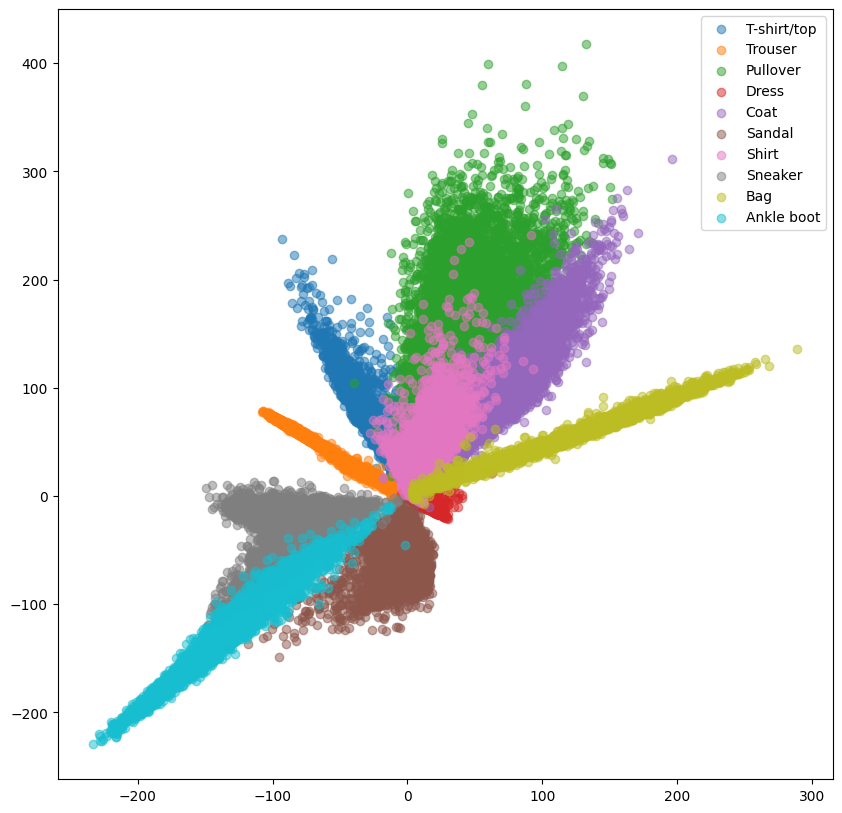

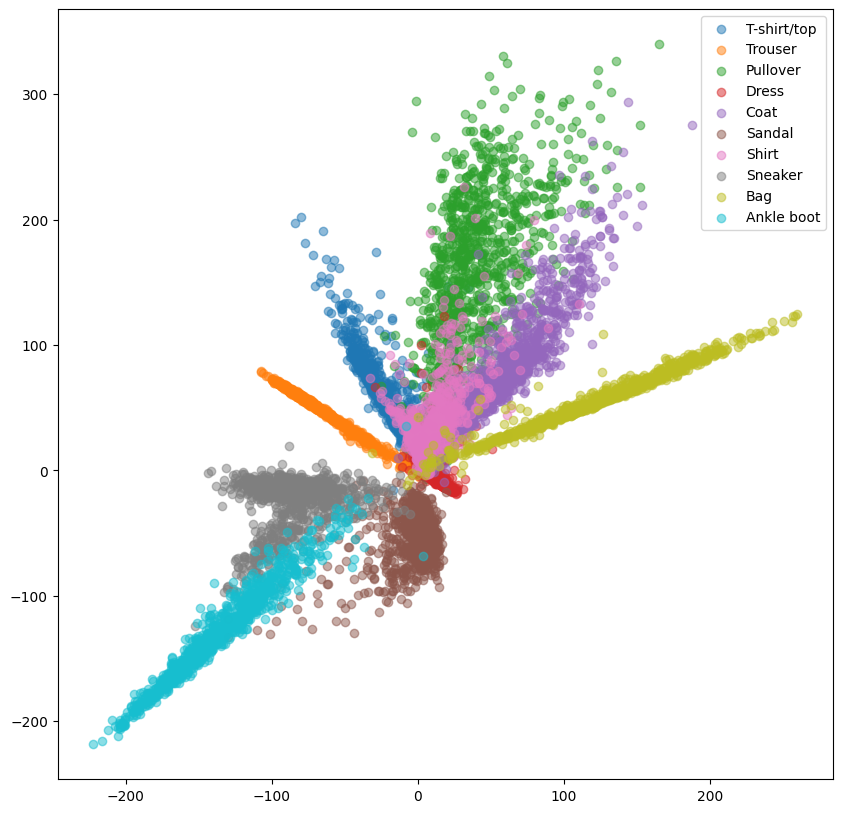

In [11]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Siamese Head

We will repeat the process with a siamese network, but in order to do that we need first to create a different dataset, that creates positive and negative pairs from the original dataset. The pairs will be generated on the fly, randomly, while training. While testing, we will maintain the same pairs always so that comparisons would make sense.

Note that here we just aim to create valid pairs, we do not do any mining (we do not care if they are easy, semi-hard or hard).

In [12]:
class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

        self.train = self.mnist_dataset.train
        self.transform = self.mnist_dataset.transform

        self.labels = self.mnist_dataset.targets
        self.data = self.mnist_dataset.data
        self.labels_set = set(self.labels.numpy())
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}

        if not self.train:
            # generate fixed pairs for testing once at initialisation
            random_state = np.random.RandomState(29) # Fix random seed for testing

            positive_pairs = [[i,
                               random_state.choice(self.label_to_indices[self.labels[i].item()]),
                               1]
                              for i in range(0, len(self.data), 2)]

            negative_pairs = [[i,
                               random_state.choice(self.label_to_indices[
                                                       np.random.choice(
                                                           list(self.labels_set - set([self.labels[i].item()]))
                                                       )
                                                   ]),
                               0]
                              for i in range(1, len(self.data), 2)]
            self.test_pairs = positive_pairs + negative_pairs

    def __getitem__(self, index):
        if self.train:
            # Generate a positive or negative pair on the fly
            target = np.random.randint(0, 2) # randomly select positive or negative
            img1, label1 = self.data[index], self.labels[index].item()
            if target == 1: # Generate a POSITIVE pair
                siamese_index = index
                while siamese_index == index: # Make sure we do not use ourself as the positive pair
                    siamese_index = np.random.choice(self.label_to_indices[label1])
            else: # Generate a NEGATIVE pair
                siamese_label = np.random.choice(list(self.labels_set - set([label1])))
                siamese_index = np.random.choice(self.label_to_indices[siamese_label])
            img2 = self.data[siamese_index]
        else:
            # Just retrieve the pair from the saved test pairs we generated at init
            img1 = self.data[self.test_pairs[index][0]]
            img2 = self.data[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        # Get a PIL image to pass through transform
        img1 = Image.fromarray(img1.numpy(), mode='L')
        img2 = Image.fromarray(img2.numpy(), mode='L')
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, target


    def __len__(self):
        return len(self.mnist_dataset)

Now we are ready to define our siamese net which just takes in one training sample (which now comprises a pair of images) and embeds them using our embedding function. It returns the two embeddings.

In [13]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.embedding_net(x)

The next thing to do is to define our loss function for the case of the siamese. In this case, we need a function that takes as input TWO vectors and one target that indicates if they are supposed to be a positive pair, or a negative pair, and implements the function:

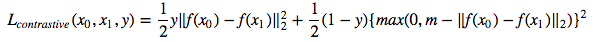

In [14]:
class ContrastiveLoss(nn.Module):
    """
    Max-Margin Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        # losses = 0.5 * (target.float() * distances + (1 - target).float() * max(0, self.margin - (distances + self.eps).sqrt()).pow(2)) equivalent to
        losses = 0.5 * (target.float() * distances + (1 - target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

We will also redefine the training and validation loops, as now the data loader gives us 2 samples and the loss function expects 2 samples.

In [15]:
def train_epoch_siamese(train_loader, model, criterion, optimizer):

    model.train()
    losses = []
    total_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(train_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        optimizer.zero_grad()

        output1, output2 = model(data1, data2)

        # The loss is the only thing we can report here
        loss = criterion(output1, output2, target)
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 20 == 0:
            print("Iteration {}: Loss = {}".format(batch_idx, loss.item()))

    total_loss /= (batch_idx + 1)
    return total_loss

@torch.no_grad()
def test_epoch_siamese(val_loader, model, criterion):

    model.eval()
    val_loss = 0
    correct = 0

    for batch_idx, (data1, data2, target) in enumerate(val_loader):
        target = target.to(device)
        data1 = data1.to(device)
        data2 = data2.to(device)

        output1, output2 = model(data1, data2)

        loss = criterion(output1, output2, target)
        val_loss += loss.item()

    return val_loss

In [16]:
siamese_train_dataset = SiameseDataset(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseDataset(test_dataset)   # Note that the train datasets has self.train == True, and the test has self.train == False

batch_size = 256
siamese_train_loader = DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True)
siamese_test_loader = DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False)

margin = 1.

embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
model.to(device)

criterion = ContrastiveLoss(margin)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)

In [17]:
n_epochs = 10 # Do 10 epochs
for epoch in range(n_epochs):

        # Train stage
        train_loss = train_epoch_siamese(siamese_train_loader, model, criterion, optimizer)
        scheduler.step()

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)

        # Validation stage
        val_loss = test_epoch_siamese(siamese_test_loader, model, criterion)
        val_loss /= len(siamese_test_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, val_loss)

        print(message)

Iteration 0: Loss = 0.24685823917388916
Iteration 20: Loss = 0.051882728934288025
Iteration 40: Loss = 0.0435016006231308
Iteration 60: Loss = 0.06758544594049454
Iteration 80: Loss = 0.056539908051490784
Iteration 100: Loss = 0.044625964015722275
Iteration 120: Loss = 0.04972060024738312
Iteration 140: Loss = 0.0439821295440197
Iteration 160: Loss = 0.046298325061798096
Iteration 180: Loss = 0.039254821836948395
Iteration 200: Loss = 0.040235113352537155
Iteration 220: Loss = 0.04166394844651222
Epoch: 1/10. Train set: Average loss: 0.0500
Epoch: 1/10. Validation set: Average loss: 0.0434
Iteration 0: Loss = 0.03791062906384468
Iteration 20: Loss = 0.04619492217898369
Iteration 40: Loss = 0.034646376967430115
Iteration 60: Loss = 0.04173964634537697
Iteration 80: Loss = 0.05187691003084183
Iteration 100: Loss = 0.0422946959733963
Iteration 120: Loss = 0.03962469473481178
Iteration 140: Loss = 0.035694800317287445
Iteration 160: Loss = 0.040002934634685516
Iteration 180: Loss = 0.04131

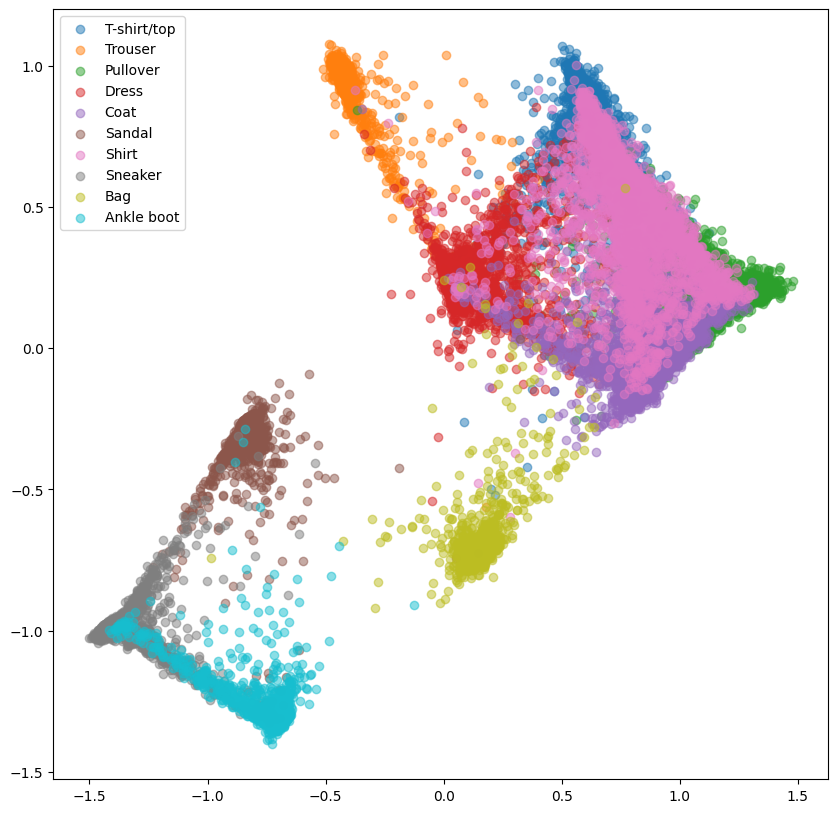

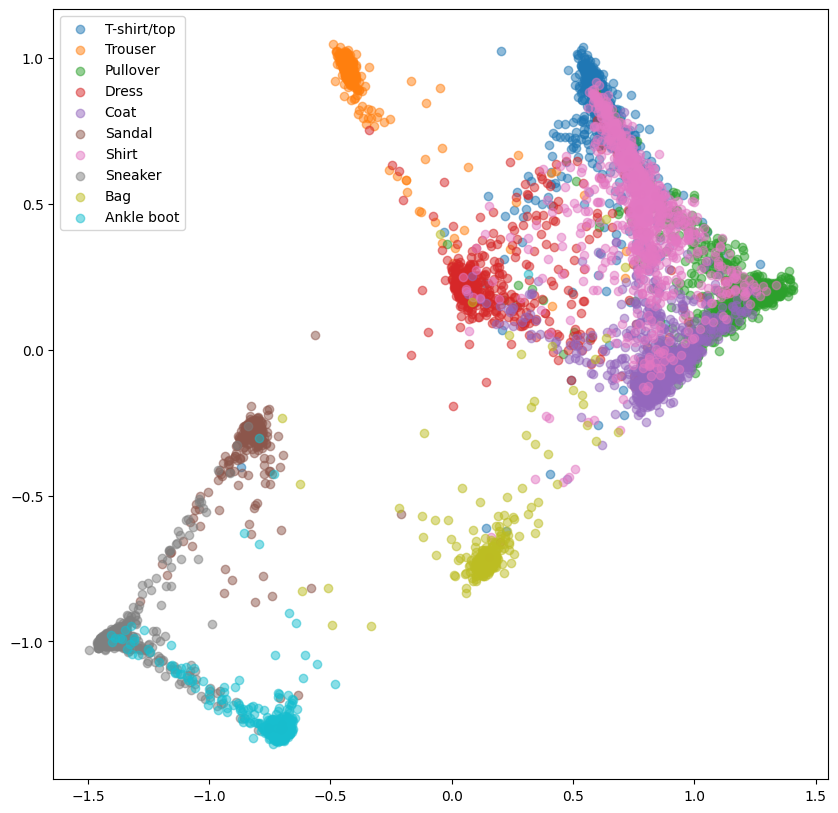

In [18]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

There are couple of problems with siamese and (triplet) networks the way we have implemented them up to this point.

- The number of possible pairs/triplets grows quadratically/cubically with the number of examples. It's infeasible to process them all
- We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with hard examples.
- Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In this case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

## Triplet Loss

We will now train FashionMNIST using a semi-hard Triplet Mining strategy, and visualize the embeddings.

We will not implement any miner, loss or distance function by hand. Instead we will use [The Pytorch Metric Learning Library](https://github.com/KevinMusgrave/pytorch-metric-learning) (installed in the cell below) which implements everything we need.

Check its [docs](https://kevinmusgrave.github.io/pytorch-metric-learning/) so that you get an idea of how to use it.

Install the required packages below. Uncomment the corresponding cell to use the package manager that suits your installation (for Google Colab, that would be pip).

In [19]:
#%conda install -y -c conda-forge pytorch-metric-learning
#%conda install -y -c conda-forge faiss-cpu

In [20]:
%pip install pytorch-metric-learning faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.9/125.9 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [21]:
from pytorch_metric_learning import losses, miners, distances, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

We will redefine our training and test loops to use this library. The idea is that first we embedd all the data inside our batch. Then we will ask a *Miner* to find good triplets. The list of triplets (a list of tuples with indices) will be passed on to the loss function, that will calculate the loss based on them.

In [22]:
def train(model, loss_func, mining_func, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        embeddings = model(data)

        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)

        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        if batch_idx % 20 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

    return total_loss / (batch_idx + 1)

def get_all_embeddings(dataset, model):
    tester = testers.BaseTester(dataloader_num_workers=2)
    return tester.get_all_embeddings(dataset, model)

def test(train_set, test_set, model, accuracy_calculator):
    model.eval()
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)

    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(query = train_embeddings, reference = test_embeddings, query_labels = train_labels, reference_labels = test_labels)

    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


We now need to define our miner. Here we will use a `TripletMarginMiner` and cosine similarity to measure the distance between embeddings. We will also use an "accuracy" calculator. The actual metric we will be using is a *precision at 1*, which is just a fancy way to ask whether the 1st nearest neighbour of each sample is of the same class.

https://kevinmusgrave.github.io/pytorch-metric-learning/accuracy_calculation/

In [23]:
distance = distances.CosineSimilarity()
mining_func = miners.TripletMarginMiner(margin = 0.2, distance=distance, type_of_triplets="all")
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k = 1)

Define the datasets, dataloaders, and the model to use. The model we will use here is just the embedding net on its own.

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

model = EmbeddingNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = losses.TripletMarginLoss(margin=1., distance = distance)

Epoch 1 Iteration 0: Loss = 0.9968231916427612, Number of mined triplets = 1474563
Epoch 1 Iteration 20: Loss = 0.9696342945098877, Number of mined triplets = 1004125
Epoch 1 Iteration 40: Loss = 0.9878404140472412, Number of mined triplets = 625520
Epoch 1 Iteration 60: Loss = 1.0100911855697632, Number of mined triplets = 537407
Epoch 1 Iteration 80: Loss = 0.9919301867485046, Number of mined triplets = 433073
Epoch 1 Iteration 100: Loss = 0.9848441481590271, Number of mined triplets = 395944
Epoch 1 Iteration 120: Loss = 1.0150049924850464, Number of mined triplets = 383306
Epoch 1 Iteration 140: Loss = 1.0209139585494995, Number of mined triplets = 343892
Epoch 1 Iteration 160: Loss = 1.0037071704864502, Number of mined triplets = 282912
Epoch 1 Iteration 180: Loss = 1.0026003122329712, Number of mined triplets = 369725
Epoch 1 Iteration 200: Loss = 1.0440961122512817, Number of mined triplets = 295917
Epoch 1 Iteration 220: Loss = 0.9757823944091797, Number of mined triplets = 314

100%|██████████| 313/313 [00:02<00:00, 136.46it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6480166666666667
Epoch 2 Iteration 0: Loss = 1.0253342390060425, Number of mined triplets = 278324
Epoch 2 Iteration 20: Loss = 0.9733722805976868, Number of mined triplets = 336041
Epoch 2 Iteration 40: Loss = 0.9708772897720337, Number of mined triplets = 270751
Epoch 2 Iteration 60: Loss = 0.9940345287322998, Number of mined triplets = 259125
Epoch 2 Iteration 80: Loss = 0.9845831394195557, Number of mined triplets = 284269
Epoch 2 Iteration 100: Loss = 0.9762945175170898, Number of mined triplets = 216764
Epoch 2 Iteration 120: Loss = 1.0287715196609497, Number of mined triplets = 233793
Epoch 2 Iteration 140: Loss = 1.0144908428192139, Number of mined triplets = 264231
Epoch 2 Iteration 160: Loss = 1.0299961566925049, Number of mined triplets = 202871
Epoch 2 Iteration 180: Loss = 1.0110961198806763, Number of mined triplets = 209864
Epoch 2 Iteration 200: Loss = 1.0552619695663452, Number of mined triplets = 243975
Epoch 2 It

100%|██████████| 313/313 [00:02<00:00, 115.51it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.6817500000000001
Epoch 3 Iteration 0: Loss = 1.0207645893096924, Number of mined triplets = 243610
Epoch 3 Iteration 20: Loss = 0.9838376641273499, Number of mined triplets = 324162
Epoch 3 Iteration 40: Loss = 0.9887133240699768, Number of mined triplets = 219465
Epoch 3 Iteration 60: Loss = 0.994267463684082, Number of mined triplets = 224754
Epoch 3 Iteration 80: Loss = 1.0195153951644897, Number of mined triplets = 262122
Epoch 3 Iteration 100: Loss = 0.9669356346130371, Number of mined triplets = 211389
Epoch 3 Iteration 120: Loss = 1.0277377367019653, Number of mined triplets = 251927
Epoch 3 Iteration 140: Loss = 0.9983085989952087, Number of mined triplets = 233025
Epoch 3 Iteration 160: Loss = 1.0102055072784424, Number of mined triplets = 222336
Epoch 3 Iteration 180: Loss = 0.9771624803543091, Number of mined triplets = 265817
Epoch 3 Iteration 200: Loss = 1.0044153928756714, Number of mined triplets = 287629
Epoch 3 Ite

100%|██████████| 313/313 [00:02<00:00, 132.54it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7132166666666667
Epoch 4 Iteration 0: Loss = 1.060475468635559, Number of mined triplets = 273742
Epoch 4 Iteration 20: Loss = 0.9737433195114136, Number of mined triplets = 217905
Epoch 4 Iteration 40: Loss = 0.9379806518554688, Number of mined triplets = 229580
Epoch 4 Iteration 60: Loss = 0.9679527282714844, Number of mined triplets = 209092
Epoch 4 Iteration 80: Loss = 1.0090186595916748, Number of mined triplets = 232391
Epoch 4 Iteration 100: Loss = 1.0070542097091675, Number of mined triplets = 200049
Epoch 4 Iteration 120: Loss = 0.9945967197418213, Number of mined triplets = 192276
Epoch 4 Iteration 140: Loss = 0.9882965087890625, Number of mined triplets = 278885
Epoch 4 Iteration 160: Loss = 0.9978650212287903, Number of mined triplets = 216035
Epoch 4 Iteration 180: Loss = 1.042352318763733, Number of mined triplets = 203001
Epoch 4 Iteration 200: Loss = 0.982587456703186, Number of mined triplets = 233381
Epoch 4 Itera

100%|██████████| 313/313 [00:02<00:00, 138.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7426666666666667
Epoch 5 Iteration 0: Loss = 0.9782347679138184, Number of mined triplets = 265097
Epoch 5 Iteration 20: Loss = 0.9769112467765808, Number of mined triplets = 170535
Epoch 5 Iteration 40: Loss = 0.9560233950614929, Number of mined triplets = 224888
Epoch 5 Iteration 60: Loss = 0.9946495294570923, Number of mined triplets = 150126
Epoch 5 Iteration 80: Loss = 1.0157647132873535, Number of mined triplets = 227461
Epoch 5 Iteration 100: Loss = 0.9861080646514893, Number of mined triplets = 241312
Epoch 5 Iteration 120: Loss = 0.9999119639396667, Number of mined triplets = 298869
Epoch 5 Iteration 140: Loss = 0.9978007078170776, Number of mined triplets = 266651
Epoch 5 Iteration 160: Loss = 0.9578005075454712, Number of mined triplets = 301236
Epoch 5 Iteration 180: Loss = 1.0371978282928467, Number of mined triplets = 224281
Epoch 5 Iteration 200: Loss = 0.9942135214805603, Number of mined triplets = 234690
Epoch 5 It

100%|██████████| 313/313 [00:02<00:00, 136.71it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7527166666666667
Epoch 6 Iteration 0: Loss = 0.9748611450195312, Number of mined triplets = 206584
Epoch 6 Iteration 20: Loss = 1.0087060928344727, Number of mined triplets = 211546
Epoch 6 Iteration 40: Loss = 0.9780252575874329, Number of mined triplets = 201126
Epoch 6 Iteration 60: Loss = 1.0041818618774414, Number of mined triplets = 164109
Epoch 6 Iteration 80: Loss = 0.9642826318740845, Number of mined triplets = 244752
Epoch 6 Iteration 100: Loss = 1.0131826400756836, Number of mined triplets = 190764
Epoch 6 Iteration 120: Loss = 0.9859673380851746, Number of mined triplets = 164581
Epoch 6 Iteration 140: Loss = 0.965032696723938, Number of mined triplets = 258105
Epoch 6 Iteration 160: Loss = 0.9664304852485657, Number of mined triplets = 188628
Epoch 6 Iteration 180: Loss = 0.9808197617530823, Number of mined triplets = 151361
Epoch 6 Iteration 200: Loss = 0.9619842171669006, Number of mined triplets = 253381
Epoch 6 Ite

100%|██████████| 313/313 [00:02<00:00, 105.99it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7784666666666668
Epoch 7 Iteration 0: Loss = 0.9535492658615112, Number of mined triplets = 190369
Epoch 7 Iteration 20: Loss = 0.979212760925293, Number of mined triplets = 161162
Epoch 7 Iteration 40: Loss = 0.9842881560325623, Number of mined triplets = 150854
Epoch 7 Iteration 60: Loss = 1.0112042427062988, Number of mined triplets = 312587
Epoch 7 Iteration 80: Loss = 0.9819698333740234, Number of mined triplets = 218678
Epoch 7 Iteration 100: Loss = 0.9850127100944519, Number of mined triplets = 176800
Epoch 7 Iteration 120: Loss = 0.980614423751831, Number of mined triplets = 163580
Epoch 7 Iteration 140: Loss = 0.9726505875587463, Number of mined triplets = 180065
Epoch 7 Iteration 160: Loss = 0.9965083003044128, Number of mined triplets = 162715
Epoch 7 Iteration 180: Loss = 0.970979630947113, Number of mined triplets = 150137
Epoch 7 Iteration 200: Loss = 0.977369487285614, Number of mined triplets = 249265
Epoch 7 Iterat

100%|██████████| 313/313 [00:02<00:00, 133.19it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.77885
Epoch 8 Iteration 0: Loss = 0.9693253636360168, Number of mined triplets = 116047
Epoch 8 Iteration 20: Loss = 0.9865795373916626, Number of mined triplets = 207092
Epoch 8 Iteration 40: Loss = 1.0011909008026123, Number of mined triplets = 211074
Epoch 8 Iteration 60: Loss = 0.9490510821342468, Number of mined triplets = 164362
Epoch 8 Iteration 80: Loss = 0.9840039610862732, Number of mined triplets = 173306
Epoch 8 Iteration 100: Loss = 0.9670616388320923, Number of mined triplets = 224722
Epoch 8 Iteration 120: Loss = 0.9618133902549744, Number of mined triplets = 198907
Epoch 8 Iteration 140: Loss = 0.9685851335525513, Number of mined triplets = 179096
Epoch 8 Iteration 160: Loss = 0.9738289713859558, Number of mined triplets = 160626
Epoch 8 Iteration 180: Loss = 0.9736276268959045, Number of mined triplets = 176443
Epoch 8 Iteration 200: Loss = 0.9994674921035767, Number of mined triplets = 230260
Epoch 8 Iteration 220

100%|██████████| 313/313 [00:03<00:00, 99.14it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.7844500000000001
Epoch 9 Iteration 0: Loss = 1.058603048324585, Number of mined triplets = 162914
Epoch 9 Iteration 20: Loss = 0.9793893098831177, Number of mined triplets = 148280
Epoch 9 Iteration 40: Loss = 0.9821799397468567, Number of mined triplets = 231523
Epoch 9 Iteration 60: Loss = 0.9657124280929565, Number of mined triplets = 140006
Epoch 9 Iteration 80: Loss = 1.0176948308944702, Number of mined triplets = 175936
Epoch 9 Iteration 100: Loss = 0.968213677406311, Number of mined triplets = 206178
Epoch 9 Iteration 120: Loss = 0.9992542862892151, Number of mined triplets = 207169
Epoch 9 Iteration 140: Loss = 0.953499436378479, Number of mined triplets = 182182
Epoch 9 Iteration 160: Loss = 0.9934995770454407, Number of mined triplets = 164024
Epoch 9 Iteration 180: Loss = 1.0162454843521118, Number of mined triplets = 231626
Epoch 9 Iteration 200: Loss = 1.0001411437988281, Number of mined triplets = 253548
Epoch 9 Itera

100%|██████████| 313/313 [00:02<00:00, 135.52it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.7764500000000001
Epoch 10 Iteration 0: Loss = 0.9539005160331726, Number of mined triplets = 230683
Epoch 10 Iteration 20: Loss = 0.9688028693199158, Number of mined triplets = 136009
Epoch 10 Iteration 40: Loss = 0.9732324481010437, Number of mined triplets = 155024
Epoch 10 Iteration 60: Loss = 0.9623388051986694, Number of mined triplets = 177360
Epoch 10 Iteration 80: Loss = 0.968242347240448, Number of mined triplets = 180557
Epoch 10 Iteration 100: Loss = 0.9571517705917358, Number of mined triplets = 167518
Epoch 10 Iteration 120: Loss = 0.9502759575843811, Number of mined triplets = 183354
Epoch 10 Iteration 140: Loss = 0.9747205376625061, Number of mined triplets = 172181
Epoch 10 Iteration 160: Loss = 1.0051071643829346, Number of mined triplets = 210448
Epoch 10 Iteration 180: Loss = 1.0420829057693481, Number of mined triplets = 153767
Epoch 10 Iteration 200: Loss = 0.9959428310394287, Number of mined triplets = 199285


100%|██████████| 313/313 [00:03<00:00, 91.83it/s] 


Computing accuracy
Test set accuracy (Precision@1) = 0.8027666666666667


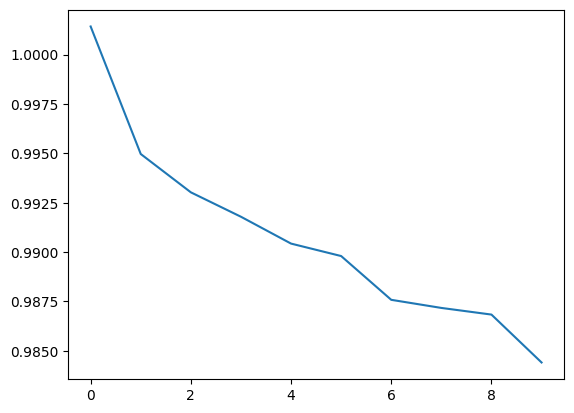

In [25]:
num_epochs = 10
loss_evolution = []

for epoch in range(1, num_epochs + 1):
    loss = train(model, loss_func, mining_func, train_loader, optimizer, epoch)
    loss_evolution.append(loss)
    test(train_dataset, test_dataset, model, accuracy_calculator)

plt.plot(loss_evolution)
plt.show()

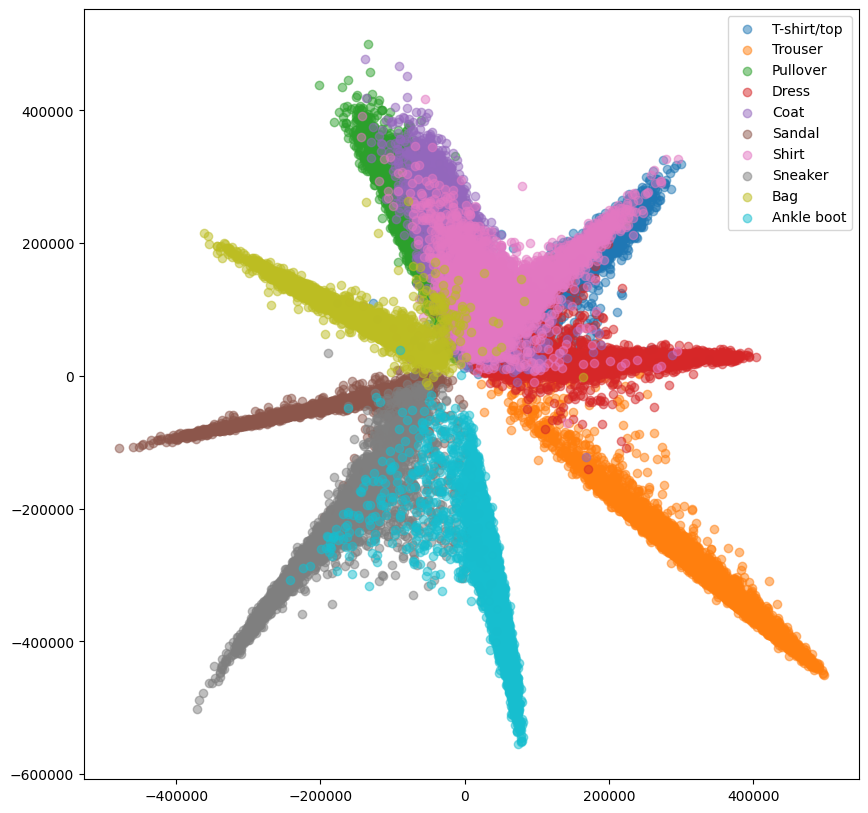

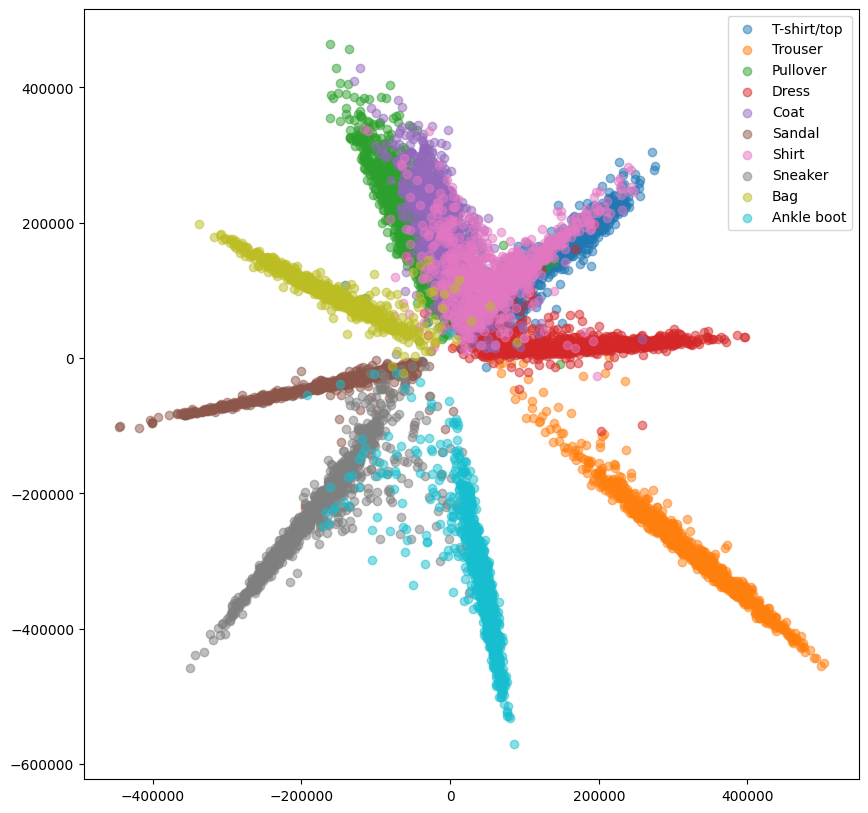

In [26]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

## Better Mining

<br>
<span style="color:blue">

**Exercise 1**: Explain the difference between semi-hard, easy and hard triplets. Try training with each type of triplets mentioned above separately and comment on the effect they have on training, using loss curves and other evidence you find necessary.
    
</span>

In [27]:
#Your Code Here


<br>
<span style="color:blue">

**Exercise 2**: Read the documentation of the PyTorch Metric Learning library and try a couple of different mining strategies, distances, margins and loss functions.
    
</span>

In [28]:
# Your Code Here


## Better embeddings

<br>
<span style="color:blue">

**Exercise 3**: Train a new (preferably more powerful) network with a 128-dimensional embedding, visualize the embedding using T-SNE.

We will use the T-SNE library from sklearn, you can see the [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for info on how to use it.

Report accuracies for both networks (the one with 2-dimensional embeddings and this one) and compare the visualizations of both embeddings.

Explanation of T-SNE [here](https://distill.pub/2016/misread-tsne/)

**Important T-SNE is rather slow so dont visualize the embeddings for every sample. Randomly select a few hundreds**

</span>

In [29]:
# Your Code Here
